# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Inicialiación

In [58]:
#Cargamos todas las librerias que creemos que vamos a utilizar
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Preparación

In [59]:
# Cargamos los datos y aseguramos  que la columna de fecha esté en el tipo datetime
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [60]:
#validamos las dimensiones del dataframe (usamos shape) e imprimimos las primeras filas (usamos head)
print(df.shape, "\n")
print(df.head(), "\n")

#mostramos la informacion del dataframe con el metodo info
df.info()

(26496, 1) 

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Duplicados y valores ausentes

In [61]:
#validamos si tenemos valores duplicados
print(df.duplicated().sum())

26415


In [62]:
#validamos si tenemos valores ausentes
print(df.isna().sum())

num_orders    0
dtype: int64


In [63]:
# Mostramos el rango de fechas de los datos
print('rango de fechas de los datos:', df.index.min(), '-', df.index.max())

rango de fechas de los datos: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


La columna datetime se convierte al tipo datetime64 y se configura como índice para trabajar correctamente con las series temporales, se realiza la validacion de los datos donde no evidenciamos valores ausentes, se evidencian valores duplicados sin embargo, es logico que nos arrojara dichos valores ya que solo tenemos una columna (num_orders) la cual se puede repetir varias veces ya que corresponde al numero de ordenes de taxis en un periodo de tiempo. 

vemos que el rango de las fechas de los datos estan desde el 01-marzo-2018 al 31-agosto-2018  y que los datos estan muestreados cada 10 minutos, de acuerdo a lo que nos pide el proyecto se requiere el muestreo cada hora.

In [64]:
# Validamos que las fechas esten en orden cronologico con el el atributo is_monotonic del índice de la tabla
print(df.index.is_monotonic)

True


In [65]:
# Remuestreamos los datos a intervalos de una hora, tomando la suma de los pedidos en cada hora
df= df.resample('1H').sum()

# Revisamos los primeros datos después del remuestreo
print(df.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


Remuestreamos los datos a intervalos de una hora usando resample('1H') y aplicamos sum() para acumular los pedidos en cada intervalo de tiempo.

## Análisis

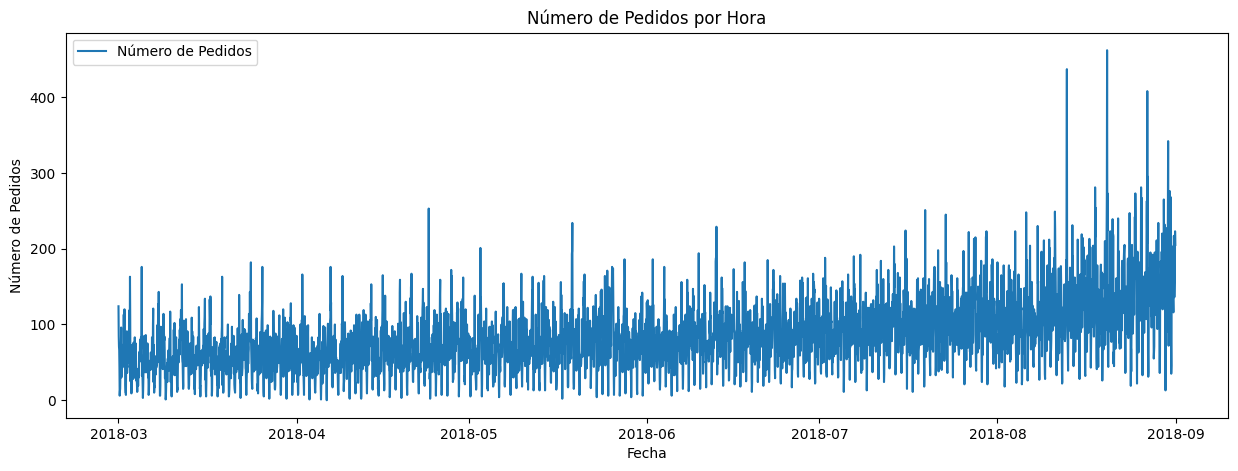

In [66]:
# Visualizamos la serie temporal con el remuestreo de 1H
plt.figure(figsize=(15, 5))
plt.plot(df['num_orders'], label='Número de Pedidos')
plt.title('Número de Pedidos por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()

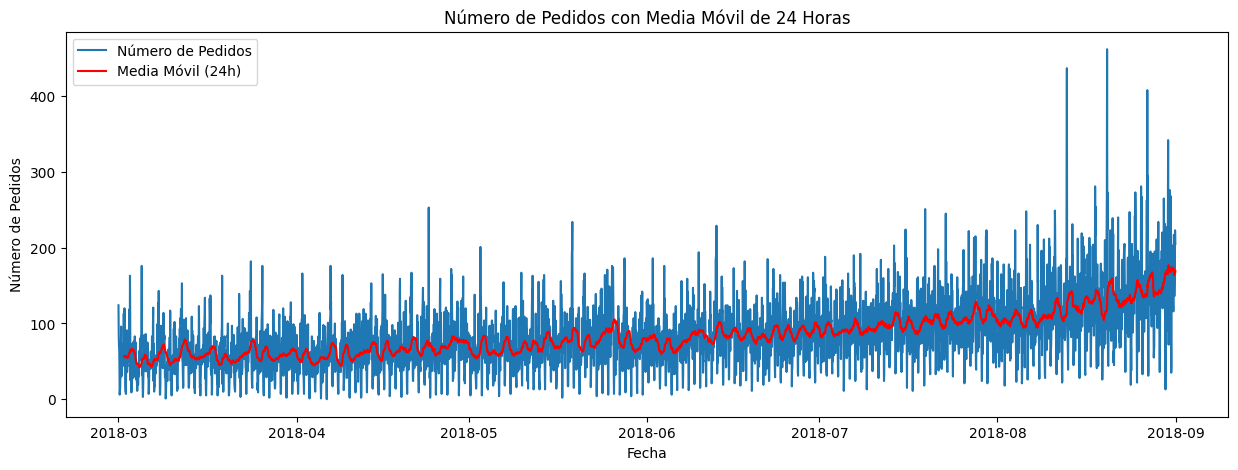

In [67]:
# Creamos nueva columna con la media móvil y graficamos
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

plt.figure(figsize=(15, 5))
plt.plot(df['num_orders'], label='Número de Pedidos')
plt.plot(df['rolling_mean'], label='Media Móvil (24h)', color='red')
plt.title('Número de Pedidos con Media Móvil de 24 Horas')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()


visualizamos la serie temporal con el número de pedidos por hora para observar patrones y posibles estacionalidades. adicionalmente, calculamos una media móvil de 24 horas para suavizar los datos y resaltar las tendencias.

### Tendencia, estacionalidad y residuos

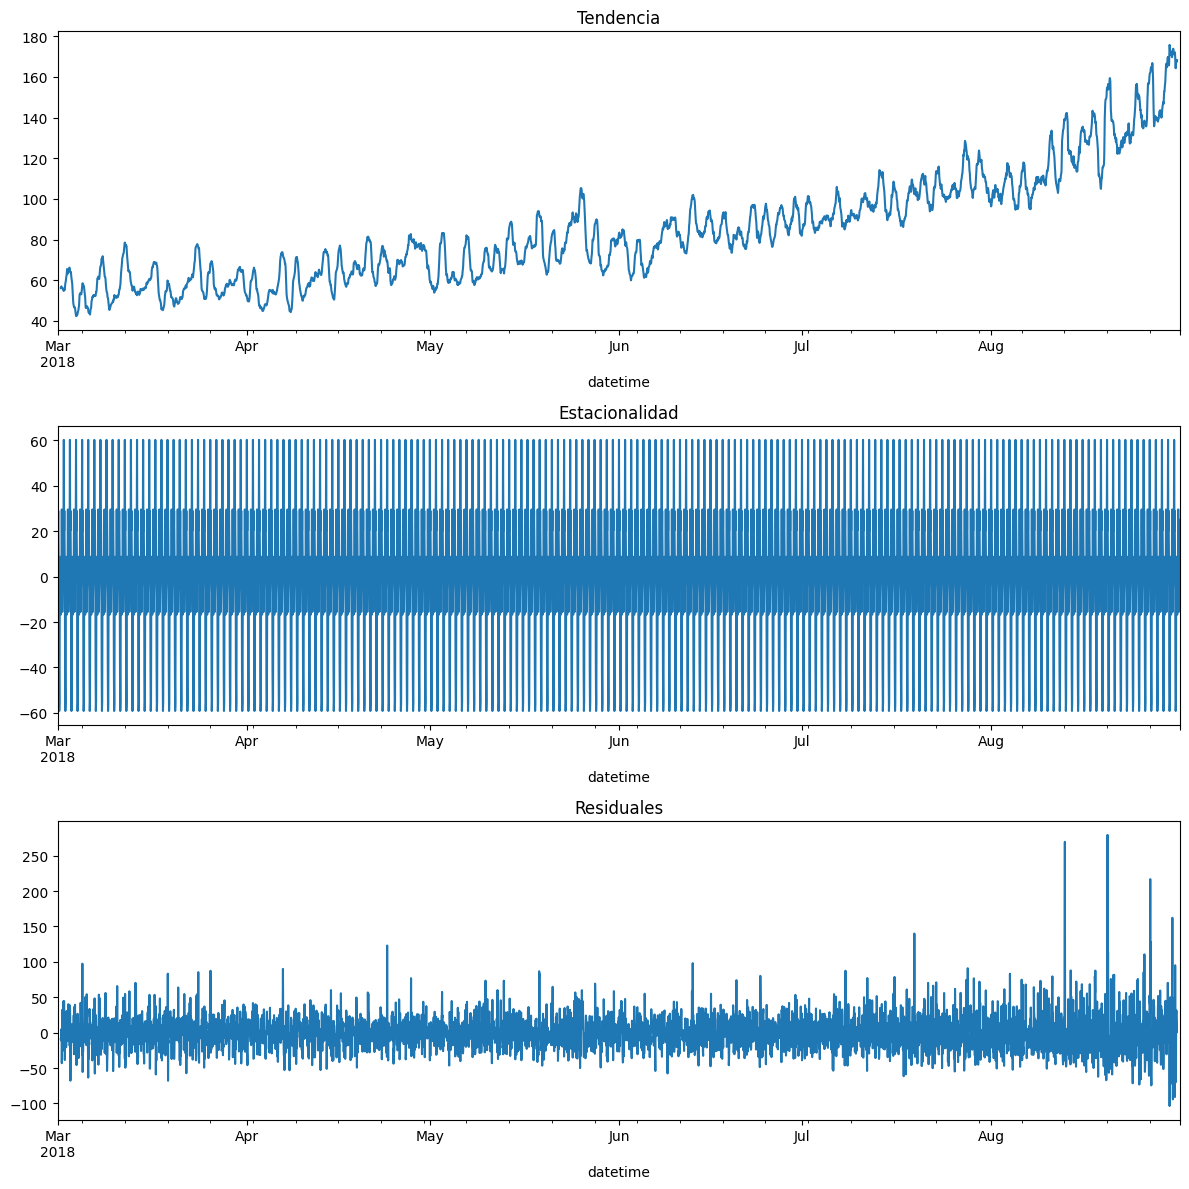

In [68]:
# dividimos la serie en los 3 componentes: tendencia, estacionalidad y residuos
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()

La primera gráfica muestra la tendencia de la serie temporal. Se observa una tendencia positiva, lo que indica que, a medida que transcurren los meses, la cantidad de taxis pedidos ha ido incrementando progresivamente. Esto podria indicar que hay un crecimiento general a lo largo del tiempo en las solicitudes de taxis.

La segunda gráfica muestra el componente estacional. Se puede ver que las fluctuaciones oscilan alrededor de cero, lo que indica que la serie temporal presenta un patrón repetitivo en ciertos períodos, pero no es lo suficientemente claro o pronunciado con los datos actuales. Esto sugiere que se necesitaría un periodo de tiempo más largo o más datos para capturar de manera adecuada los ciclos estacionales.

La tercera gráfica representa los residuos o ruido de la serie temporal, es decir, la variabilidad que no puede ser explicada ni por la tendencia ni por la estacionalidad. Aquí, podemos ver la presencia de valores atípicos (outliers), particularmente en el mes de agosto, donde los residuos muestran un aumento, lo que indiaria un cambio inusual en ese mes que afectó el comportamiento de la serie.

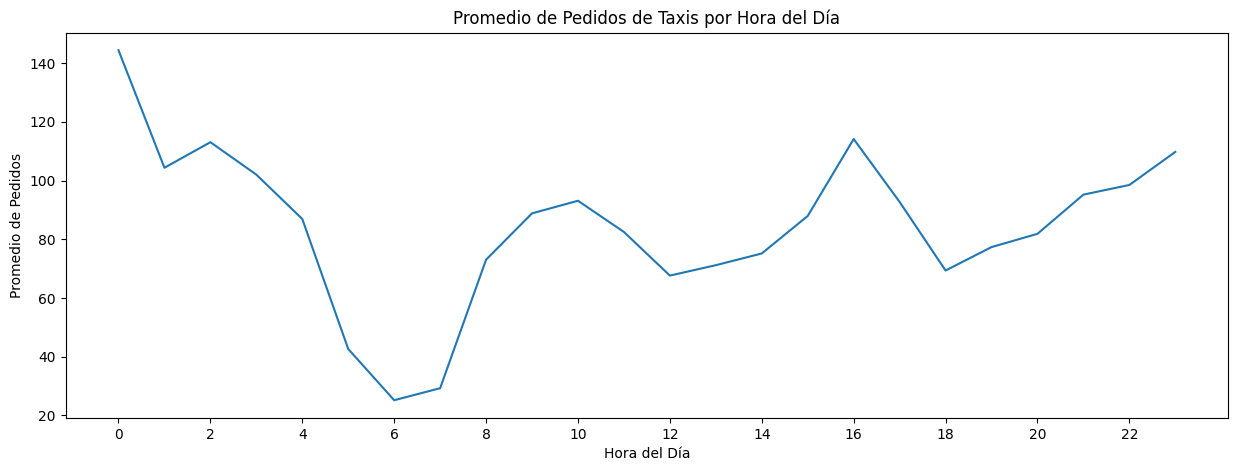

In [69]:
# Agrupamos por hora y calculamos el promedio de los pedidos
orders_by_hour = df.groupby(df.index.hour)['num_orders'].mean()

plt.figure(figsize=(15, 5))
orders_by_hour.plot()
plt.xticks(range(0, 24, 2))
plt.title('Promedio de Pedidos de Taxis por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Pedidos')
plt.show()


Las horas de menor demanda son probablemente las primeras horas de la mañana (5:00 a 7:00 AM) y la hora del almuerzo, donde hay menos necesidad de taxis.

Se observa que entre las 12:00 am y 2:00 am tienen un número alto de pedidos, lo que podría indicar que las personas están regresando a casa después de salir o necesitan transporte nocturno. Y se tiene un segundo pico en las horas de la tarde (15:00 - 17:00), que refleja tambien alta demanda de taxis, lo que podria indicar que es cuando la gente esta regresando a casa.

## Formación

Se realizara la creación de caracteristicas para un horizonte de pronóstico con el fin de entrenar diferentes modelos con diferentes hiperparametros.

caracteristicas de calendario: Por lo general, las tendencias y la estacionalidad se vinculan con una fecha específica. se tendra en cuenta dia del mes (day), dia de la semana (dayofweek), el mes (month), la hora (hour).

caracteristicas de desfase: Los valores anteriores en la serie temporal nos dirán si aumentará o disminuirá.

caracteristica de media movil: La característica de media móvil establece la tendencia general de la serie temporal. (Ya hallada previamente)

In [70]:
# Creamos las caracteristicas de calendario
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

# Creamos las características de desfase (lags)
max_lag = 3
for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag) 

#mostramos la tabla
df.head(10)

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,NaN,3,1,3,4,66.0,71.0,85.0
2018-03-01 05:00:00,6,NaN,3,1,3,5,43.0,66.0,71.0
2018-03-01 06:00:00,12,NaN,3,1,3,6,6.0,43.0,66.0
2018-03-01 07:00:00,15,NaN,3,1,3,7,12.0,6.0,43.0
2018-03-01 08:00:00,34,NaN,3,1,3,8,15.0,12.0,6.0


### División de los datos en entrenamiento y prueba

In [71]:
# Eliminamos filas con valores NaN
df = df.dropna()

# Separamos las características (X) y el objetivo (y)
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

# Dividir en conjunto de entrenamiento (90%) y prueba (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# mostramos los tamaños de los conjuntos de entrenamiento y prueba
print(X_train.shape)
print(X_test.shape)

(3952, 8)
(440, 8)


In [72]:
# Verificamos que las fechas del conjunto de entrenamiento sean anteriores a las del conjunto de prueba
print('Conjunto de entrenamiento:', X_train.index.min(), '-', X_train.index.max())
print('Conjunto de prueba:', y_test.index.min(), '-', y_test.index.max())

Conjunto de entrenamiento: 2018-03-02 00:00:00 - 2018-08-13 15:00:00
Conjunto de prueba: 2018-08-13 16:00:00 - 2018-08-31 23:00:00


### Entrenamiento de diferentes modelos y evaluación

In [73]:
# Definimos la estrategia de validación cruzada (TimeSeriesSplit)
tss = TimeSeriesSplit(n_splits=3)

#### Modelo Regresión Lineal

In [74]:
# Entrenamos modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


LinearRegression()

#### Modelo Arbol de Decisión

In [75]:
# Usamos GridSearchCV para encontrar los mejores hiperparametros para el modelo
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializamos el modelo
model_dt = DecisionTreeRegressor(random_state=12345)

# Aplicamos GridSearchCV
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_dt.fit(X_train, y_train)

# Guardamos el mejor modelo y sus métricas
best_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_
rmse_dt = -grid_search_dt.best_score_

print(f'Mejores hiperparámetros: {best_params_dt}')
print(f'Mejor modelo de Árbol de Decisión - RMSE: {rmse_dt:.2f}')

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mejor modelo de Árbol de Decisión - RMSE: 30.52


#### Modelo Bosque Aleatorio

In [76]:
# Usamos GridSearchCV para encontrar los mejores hiperparametros para el modelo
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Inicializamos el modelo
model_rf = RandomForestRegressor(random_state=12345)

# Aplicamos GridSearchCV
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

# Guardamos el mejor modelo y sus métricas
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
rmse_rf = -grid_search_rf.best_score_

print(f'Mejores hiperparámetros: {best_params_rf}')
print(f'Mejor modelo de Bosque Aleatorio - RMSE: {rmse_rf:.2f}')

Mejores hiperparámetros: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}
Mejor modelo de Bosque Aleatorio - RMSE: 27.18


#### Modelo LightGBM

In [79]:
# Usamos GridSearchCV para encontrar los mejores hiperparametros para el modelo
param_grid_lgbm = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.05, 0.1],
    'num_leaves':[10, 15, 20],
    'objective':['rmse']
}

# Inicializamos el modelo
model_lgbm = LGBMRegressor(random_state=12345)

# Aplicamos GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid_lgbm, cv=tss, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid_search_lgbm.fit(X_train, y_train)

# Guardamos el mejor modelo y sus métricas
best_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_
rmse_lgbm = -grid_search_lgbm.best_score_

print(f'Mejores hiperparámetros: {best_params_lgbm}')
print(f'Mejor modelo de LightGBM - RMSE: {rmse_lgbm:.2f}')

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 30, 'num_leaves': 20, 'objective': 'rmse'}
Mejor modelo de LightGBM - RMSE: 27.76


#### Modelo CatBoost

In [80]:
# Usamos GridSearchCV para encontrar los mejores hiperparametros para el modelo
param_grid_cat = {
    'iterations': [10, 25, 100],
    'learning_rate': [0.5, 0.1],
    'depth': [6, 10, 15],
    'loss_function':['RMSE']
}

# Inicializamos el modelo
model_cat = CatBoostRegressor(random_state=12345, verbose=False)

# Aplicamos GridSearchCV
grid_search_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid_cat, n_jobs=-1, cv=tss, scoring='neg_root_mean_squared_error')
grid_search_cat.fit(X_train, y_train)

# Guardamos el mejor modelo y sus métricas
best_cat = grid_search_cat.best_estimator_
best_params_cat = grid_search_cat.best_params_
rmse_cat = -grid_search_cat.best_score_

print(f'Mejores hiperparámetros: {best_params_cat}')
print(f'Mejor modelo de CatBoost - RMSE: {rmse_cat:.2f}')


Mejores hiperparámetros: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'RMSE'}
Mejor modelo de CatBoost - RMSE: 27.32


## Prueba

Se procederá a evaluar cada uno de los modelos vistos anteriormente con el conjunto de prueba, para lo cual se usa cada uno de los modelos con sus mejores hiperparametros y se calcula el valor del rmse. 

#### Modelo Regresión Lineal

In [81]:
# Evaluamos el modelo de Regresion Lineal en el conjunto de prueba
y_pred_lr = model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
print(f'Regresión Lineal - RMSE en Prueba: {rmse_lr:.2f}')

Regresión Lineal - RMSE en Prueba: 51.43


#### Modelo Arbol de Decisión

In [82]:
# Evaluamos el modelo de Árbol de Decisión ajustado en el conjunto de prueba
y_pred_dt = best_dt.predict(X_test)
rmse_dt_test = mean_squared_error(y_test, y_pred_dt, squared=False)
print(f'Árbol de Decisión (Ajustado) - RMSE en Prueba: {rmse_dt_test:.2f}')


Árbol de Decisión (Ajustado) - RMSE en Prueba: 51.79


#### Modelo Bosque Aleatorio

In [83]:
# Evaluamos el modelo de Bosque Aleatorio ajustado en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)
rmse_rf_test = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f'Bosque Aleatorio (Ajustado) - RMSE en Prueba: {rmse_rf_test:.2f}')

Bosque Aleatorio (Ajustado) - RMSE en Prueba: 47.49


#### Modelo LightGBM

In [84]:
# Evaluamos el modelo de LightGBM ajustado en el conjunto de prueba
y_pred_lgbm = best_lgbm.predict(X_test)
rmse_lgbm_test = mean_squared_error(y_test, y_pred_lgbm, squared=False)
print(f'LightGBM (Ajustado) - RMSE en Prueba: {rmse_lgbm_test:.2f}')

LightGBM (Ajustado) - RMSE en Prueba: 47.66


#### Modelo CatBoost

In [85]:
# Evaluamos el modelo XGBoost ajustado en el conjunto de prueba
y_pred_cat = best_cat.predict(X_test)
rmse_cat_test = mean_squared_error(y_test, y_pred_cat, squared=False)
print(f'CatBoost (Ajustado) - RMSE en Prueba: {rmse_cat_test:.2f}')

CatBoost (Ajustado) - RMSE en Prueba: 47.30


In [88]:
# Guardamos los resultados en un DataFrame
results = {
    'Modelo': ['Regresión Lineal', 'Arbol de Decisión', 'Bosque Aleatorio', 'LightGBM', 'CatBoost'],
    'RMSE en Prueba': [rmse_lr, rmse_dt_test, rmse_rf_test, rmse_lgbm_test, rmse_cat_test]
}

df_results = pd.DataFrame(results)
df_results.sort_values('RMSE en Prueba', inplace = True)
df_results

,Modelo,RMSE en Prueba
4,CatBoost,47.297464
2,Bosque Aleatorio,47.486908
3,LightGBM,47.656087
0,Regresión Lineal,51.428482
1,Arbol de Decisión,51.786289


## Conclusión

Los mejores modelos en términos de precisión (RMSE en el conjunto de prueba) son CatBoost y el Bosque Aleatorio, con RMSE de 47.30 y 47.49 respectivamente. Estos modelos cumplen con la meta de un RMSE menor a 48 en el conjunto de prueba, demostrando ser efectivos para la predicción de la demanda de taxis.

La Regresión Lineal tuvo el mayor RMSE (51.43), mostrando un desempeño adecuado como modelo de referencia. La regresión lineal es útil como prueba de cordura para confirmar que otros modelos complejos, como los de potenciación del gradiente y ensamble, puedan mejorar el rendimiento.

LightGBM fue competitivo, logrando un RMSE de 47.66, ligeramente más alto que CatBoost y el Bosque Aleatorio.

CatBoost es la opción recomendada por su precisión, cumplimiento del RMSE requerido y eficiencia en el manejo de características categóricas. Alternativamente, el Bosque Aleatorio y LightGBM también ofrecen buenos resultados y podrían considerarse según los requisitos de implementación (como el tiempo de entrenamiento y recursos computacionales).

Estos modelos podrían proporcionar la confianza para predecir la demanda de taxis en la app, lo cual ayudaria a la empresa Sweet Lift Taxi a mejorar la experiencia del usuario y optimizar la asignación de conductores en períodos de alta demanda.